In [1]:
!python -V

Python 3.10.12


In [2]:
!pip list

Package                  Version
------------------------ ---------
absl-py                  1.4.0
anyio                    3.6.2
appnope                  0.1.3
argon2-cffi              21.3.0
argon2-cffi-bindings     21.2.0
array-record             0.2.0
arrow                    1.2.3
asttokens                2.2.1
astunparse               1.6.3
attrs                    23.1.0
backcall                 0.2.0
beautifulsoup4           4.12.2
bleach                   6.0.0
cachetools               5.3.0
certifi                  2023.5.7
cffi                     1.15.1
charset-normalizer       3.1.0
click                    8.1.3
comm                     0.1.3
contourpy                1.0.7
cycler                   0.11.0
debugpy                  1.6.7
decorator                5.1.1
defusedxml               0.7.1
dm-tree                  0.1.8
etils                    1.3.0
exceptiongroup           1.1.1
executing                1.2.0
fastjsonschema           2.16.3
flatbuffers            

In [3]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 1. Load VGG16 Model

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [7]:
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(256, 256, 3))
base_model.trainable = False ## Not trainable weights
print("model summary 1")
base_model.summary()
print("Is layer Not trainable weights?")
for layer in base_model.layers:
    print(layer, layer.trainable)

model summary 1
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 1

# 2. Fine Chuning Model

In [8]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping

In [9]:
model = Sequential()

model.add(base_model)

model.add(Conv2D(64, kernel_size=3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu")) 
model.add(Dense(64, activation="relu")) 
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [10]:
for layer in model.layers:
    print(layer, layer.trainable )

print(len(model.trainable_weights))

<keras.src.engine.functional.Functional object at 0x286086710> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x285d257b0> True
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x108b13bb0> True
<keras.src.layers.regularization.dropout.Dropout object at 0x285fcd1e0> True
<keras.src.layers.reshaping.flatten.Flatten object at 0x289926a70> True
<keras.src.layers.core.dense.Dense object at 0x289927cd0> True
<keras.src.layers.regularization.dropout.Dropout object at 0x285d0f850> True
<keras.src.layers.core.dense.Dense object at 0x285d0f6d0> True
<keras.src.layers.core.dense.Dense object at 0x16943d9c0> True
<keras.src.layers.regularization.dropout.Dropout object at 0x16943dc90> True
<keras.src.layers.core.dense.Dense object at 0x108aec6a0> True
10


In [11]:
from keras.callbacks import EarlyStopping

In [12]:
model.compile(
    optimizer= 'adam', 
    loss=tf.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 64)          294976    
                                                                 
 max_pooling2d (MaxPooling2  (None, 4, 4, 64)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4, 4, 64)          0         
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                        

# 3. Remove dodgy images

In [14]:
import cv2
import imghdr

In [15]:
data_dir = 'data3' 

In [16]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [17]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

Image not in ext list data3/1_poison/world523.jpg
Image not in ext list data3/1_poison/world480.jpg
Image not in ext list data3/1_poison/world18.jpg
Image not in ext list data3/1_poison/world253.jpg
Image not in ext list data3/1_poison/world478.jpg
Image not in ext list data3/1_poison/world530.jpg
Image not in ext list data3/1_poison/world524.jpg
Image not in ext list data3/1_poison/.DS_Store
Image not in ext list data3/1_poison/indian16.jpg
Image not in ext list data3/1_poison/world718.jpg
Image not in ext list data3/1_poison/world346.jpg
Image not in ext list data3/1_poison/world655.jpeg
Image not in ext list data3/1_poison/world218.jpg
Image not in ext list data3/1_poison/world769.jpg
Image not in ext list data3/1_poison/world219.jpg
Image not in ext list data3/1_poison/world386.jpg
Image not in ext list data3/1_poison/world806.jpg
Image not in ext list data3/1_poison/world816.jpg
Image not in ext list data3/1_poison/world220.jpg
Image not in ext list data3/1_poison/world368.jpg
Ima

# 4. Load Data

In [18]:
import numpy as np
from matplotlib import pyplot as plt

In [19]:
data= tf.keras.utils.image_dataset_from_directory('data3')

Found 1635 files belonging to 2 classes.


In [20]:
data_iterator = data.as_numpy_iterator()

2023-08-03 19:27:50.383932: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]
2023-08-03 19:27:50.384480: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]


In [21]:
batch = data_iterator.next()

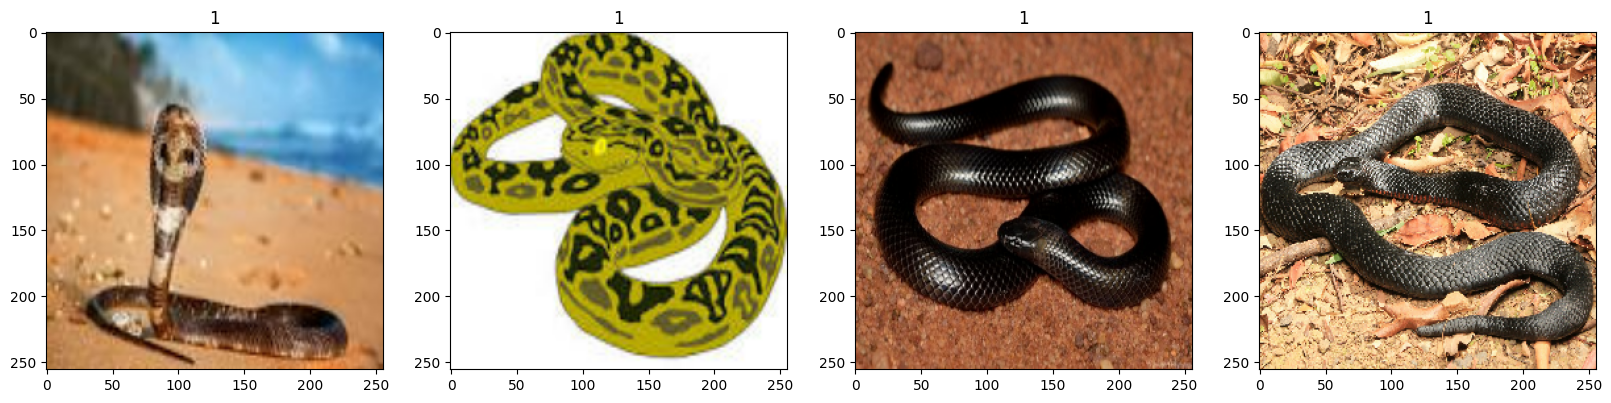

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 5. Scale Data

In [23]:
data = data.map(lambda x,y: (x/255, y))

In [24]:
data.as_numpy_iterator().next()

2023-08-03 19:28:01.673199: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]
2023-08-03 19:28:01.673529: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1635]
	 [[{{node Placeholder/_0}}]]


(array([[[[0.24705882, 0.22352941, 0.16078432],
          [0.24705882, 0.22352941, 0.16078432],
          [0.24705882, 0.22352941, 0.16078432],
          ...,
          [0.40784314, 0.3764706 , 0.33333334],
          [0.40784314, 0.3764706 , 0.33333334],
          [0.40784314, 0.3764706 , 0.33333334]],
 
         [[0.24705882, 0.22352941, 0.16078432],
          [0.24705882, 0.22352941, 0.16078432],
          [0.24705882, 0.22352941, 0.16078432],
          ...,
          [0.40784314, 0.3764706 , 0.33333334],
          [0.40784314, 0.3764706 , 0.33333334],
          [0.40784314, 0.3764706 , 0.33333334]],
 
         [[0.24705882, 0.22352941, 0.16078432],
          [0.24705882, 0.22352941, 0.16078432],
          [0.24705882, 0.22352941, 0.16078432],
          ...,
          [0.40784314, 0.3764706 , 0.33333334],
          [0.40784314, 0.3764706 , 0.33333334],
          [0.40784314, 0.3764706 , 0.33333334]],
 
         ...,
 
         [[0.6745098 , 0.6392157 , 0.5803922 ],
          [0.67450

# 6. Split Data

In [25]:
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = len(data) - train_size - val_size

In [26]:
len(data)

52

In [27]:
train_size

36

In [28]:
val_size

10

In [29]:
test_size

6

In [30]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 7. Train

In [31]:
logdir='logs'

In [32]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [33]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20


2023-08-03 19:28:12.875952: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]
2023-08-03 19:28:12.876239: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1635]
	 [[{{node Placeholder/_0}}]]


36/36 [==============================] - ETA: 0s - loss: 0.5898 - accuracy: 0.7569

2023-08-03 19:33:40.674987: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]
2023-08-03 19:33:40.675150: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]


36/36 [==============================] - 376s 11s/step - loss: 0.5898 - accuracy: 0.7569 - val_loss: 0.5225 - val_accuracy: 0.7656
Epoch 2/20
36/36 [==============================] - 957s 27s/step - loss: 0.4832 - accuracy: 0.7821 - val_loss: 0.4718 - val_accuracy: 0.7437
Epoch 3/20
36/36 [==============================] - 315s 9s/step - loss: 0.4328 - accuracy: 0.7769 - val_loss: 0.4476 - val_accuracy: 0.7656
Epoch 4/20
36/36 [==============================] - 244s 7s/step - loss: 0.4109 - accuracy: 0.7891 - val_loss: 0.3884 - val_accuracy: 0.7719
Epoch 5/20
36/36 [==============================] - 244s 7s/step - loss: 0.3755 - accuracy: 0.8021 - val_loss: 0.3659 - val_accuracy: 0.8500
Epoch 6/20
36/36 [==============================] - 253s 7s/step - loss: 0.3755 - accuracy: 0.8125 - val_loss: 0.3873 - val_accuracy: 0.8375
Epoch 7/20
36/36 [==============================] - 261s 7s/step - loss: 0.3446 - accuracy: 0.8273 - val_loss: 0.3423 - val_accuracy: 0.8250
Epoch 8/20
36/36 [====

# 8. Plot Performance

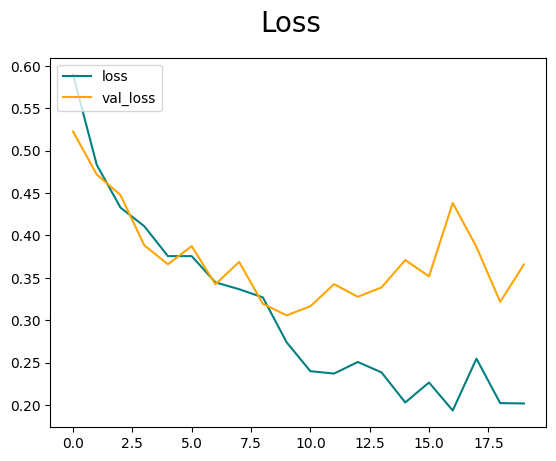

In [34]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

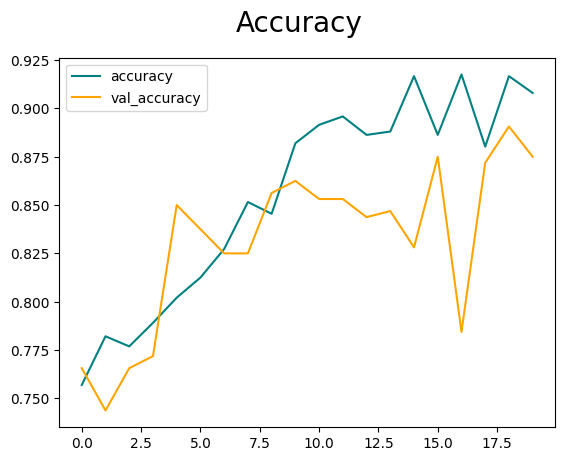

In [35]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate by test

In [36]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [37]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [38]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

2023-08-03 21:17:20.633691: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]
2023-08-03 21:17:20.634394: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1635]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 1s 596ms/step


In [39]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.92436975, shape=(), dtype=float32) tf.Tensor(0.88, shape=(), dtype=float32) tf.Tensor(0.85276073, shape=(), dtype=float32)


# 10. Save the Model

In [40]:
from keras.models import load_model

In [41]:
model.save(os.path.join('models','imageclassifier.h5'))

/Users/sakuhongenki/.venv/pre/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [42]:
new_model = load_model('models/imageclassifier.h5')

In [43]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 417ms/step


In [46]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.97727275, shape=(), dtype=float32) tf.Tensor(0.84313726, shape=(), dtype=float32) tf.Tensor(0.9052632, shape=(), dtype=float32)
